In [1]:
import os
from os import path
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import io
import scipy as scipy
import collections
import scipy.sparse as sp_sparse
import tables
import time
import numba as nb
from numba import config
from numba_progress import ProgressBar
import ipdb
import matplotlib as plt
from tqdm.notebook import tqdm


from ABCA7lof2.setup import get_data, save_all, save_annotations, subset_mat
from ABCA7lof2.qc import filter_cells, filter_cells_by_major_annotation, filter_on_gaussian_logliklihood, get_total_counts, log_normalize_counts
from ABCA7lof2.annotation import get_major_annotations


config.THREADING_LAYER = 'workqueue'

In [2]:
# define paths
meta_path = './raw_data/cellranger_counts_out/aggr_out/metadata.npy'
features_name_path = './raw_data/cellranger_counts_out/aggr_out/features_name.npy'
matrix_path = './raw_data/cellranger_counts_out/aggr_out/counts.npy'
features_id_path = './raw_data/cellranger_counts_out/aggr_out/features_id.npy'
barcodes_path = './raw_data/cellranger_counts_out/aggr_out/barcodes.npy'

# load data
counts = np.lib.format.open_memmap(matrix_path, mode='r')
features_name = np.lib.format.open_memmap(features_name_path, mode='r')
features_id = np.lib.format.open_memmap(features_id_path, mode='r')
barcodes = np.lib.format.open_memmap(barcodes_path, mode='r')
meta = np.load(meta_path, allow_pickle=True)

# get column names
meta_col_names = np.array(pd.read_csv('./raw_data/metadata/single_cell_individual_metadata.csv', index_col=0).columns)

# run checks
temp = features_name.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature names were aggregated correctly across samples.')
    
temp = features_id.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature IDs were aggregated correctly across samples.')
    
# concatenate features and metadata
features = np.concatenate((features_name[:counts.shape[1]].reshape(-1,1), features_id[:counts.shape[1]].reshape(-1,1)), axis=1)
meta = np.concatenate((barcodes.reshape(-1,1), meta), axis=1)


Feature names were aggregated correctly across samples.
Feature IDs were aggregated correctly across samples.


Quality control for cell inclusion
Outlier cells with less than 500 or more than 10,000 genes detected were excluded, and only genes detected in at least 10 cells were considered. The following quality measures were quantified for each cell: (1) the number of genes for which at least one read was mapped (indicative of library complexity); (2) the total number of counts; and (3) the percentage of reads mapped to mitochondrial genes (used to approximate the relative amount of endogenous RNA and commonly used as a measure of cell quality). Cells with a discriminatively high ratio of mitochondrial to non-mitochondrial read counts were excluded using unbiased k-means clustering-based binarization (k = 2). Nuclear-encoded protein-coding genes were considered for downstream analyses.



Labels = [0 1]
counts per label = [124279  26156]


  0%|          | 0/124279 [00:00<?, ?it/s]

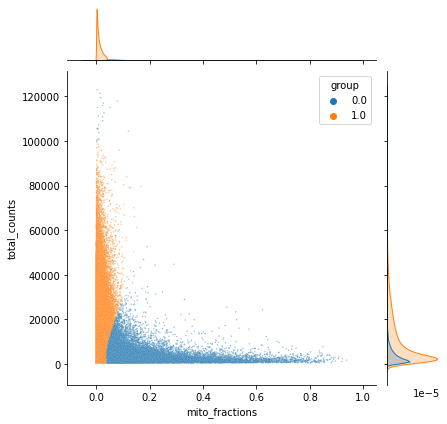

In [3]:
# filter by cells prior to annotation
pdf = plt.backends.backend_pdf.PdfPages('./pdf_figures/single_cell_qc.pdf')
mito_index, total_counts, mito_fractions, filtered_meta, filtered_counts  = filter_cells(features[:,0], counts, meta, 1, 500, 100000, pdf, 'MT-', './processed_data/single_cell')

In [4]:
#annotating major cell types
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations('./processed_data/single_cell/brain_marker_genes.csv', features[:,0], filtered_counts, total_counts, 1, 20, 8, './processed_data/single_cell', None)

using prior markers for reduction & annotation...
getting marker indices...
getting normalized marker matrix...


  0%|          | 0/124279 [00:00<?, ?it/s]

running pca...
estimating gaussian mixture model...
computing celltype summary scores...
annotating cell types...


In [5]:
print('filtering by logliklihood')
keep_cells_1 = filter_on_gaussian_logliklihood(scores)

filtering by logliklihood


In [6]:
individual_annotation = filtered_meta[:,2]
keep_cells_2, keep_cells_mito, keep_cells_individual, keep_genes, keep_individuals = filter_cells_by_major_annotation(mito_fractions, total_counts, 1, predict, individual_annotation, filtered_counts)

Filtering Cells by major annotation.
Labels = [0 1]
counts per label = [28608  6137]
Labels = [0 1]
counts per label = [1666 1273]
Labels = [0 1]
counts per label = [7036 2568]
Labels = [0 1]
counts per label = [2900 8733]
Labels = [0 1]
counts per label = [1611 5183]
Labels = [0 1]
counts per label = [2725 2391]
Labels = [0 1]
counts per label = [2595 5075]
Labels = [0 1]
counts per label = [21756 24022]


  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

In [7]:
((np.unique(annotations, return_counts=True))[1])/np.sum((np.unique(annotations, return_counts=True))[1])

array([0.07727774, 0.39199704, 0.13476935, 0.06171598, 0.27957257,
       0.05466732])

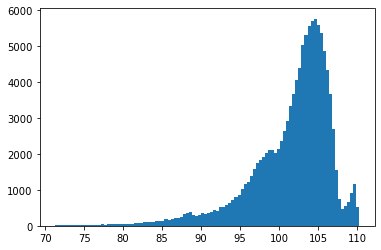

In [24]:
plt.pyplot.hist(scores[keep_cells_1&keep_cells_2], 100)
None

In [20]:
np.unique(annotations[keep_cells_1&keep_cells_2&np.array(scores>90)], return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype='<U3'),
 array([ 8465, 43474, 15275,  6815, 33001,  6039]))

In [12]:
np.unique(annotations, return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype='<U3'),
 array([ 9604, 48717, 16749,  7670, 34745,  6794]))

In [27]:
# compile metadata
filtered_meta_final = np.concatenate((filtered_meta,(keep_cells_1&keep_cells_2).reshape(-1,1), keep_cells_mito.reshape(-1,1), keep_cells_individual.reshape(-1,1), (scores>90).reshape(-1,1), predict.reshape(-1,1), scores.reshape(-1,1), annotations.reshape(-1,1), total_counts.reshape(-1,1), mito_fractions.reshape(-1,1)), axis = 1)
meta_names = np.concatenate((np.concatenate((np.array(['barcodes','index']), meta_col_names), axis=0), np.array(('keep_cells_all_per_celltype', 'keep_cells_mito_per_celltype', 'keep_cells_individual', 'keep_cells_gaussian', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions'))), axis = 0)

In [28]:
# save data
np.save('./processed_data/single_cell/filtered_meta.npy', filtered_meta_final)
np.save('./processed_data/single_cell/meta_names.npy', meta_names)
np.save('./processed_data/single_cell/features.npy', features)
np.save('./processed_data/single_cell/projected_matrix.npy', projected_matrix)
np.save('./processed_data/single_cell/marker_indices.npy', marker_indices)

In [10]:
# normalize counts
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='w+', shape=filtered_counts.shape, dtype='float')
log_normalize_counts(filtered_counts, total_counts, logcounts)

100%|██████████| 124279/124279 [01:56<00:00, 1065.02it/s]
